In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.feature import hog

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from xgboost import XGBClassifier

In [4]:
!pip install xgboost

In [5]:
import os
import pandas as pd

DATASET_DIR = "/content/drive/MyDrive/Malaria_aug"  # change to your dataset path

data = []

for label in os.listdir(DATASET_DIR):
    class_dir = os.path.join(DATASET_DIR, label)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            data.append({
                "image_path": img_path,
                "label": label
            })

df = pd.DataFrame(data)
df.head()

,image_path,label
0,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
1,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
2,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
3,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax
4,/content/drive/MyDrive/Malaria_aug/Vivax/17031...,Vivax


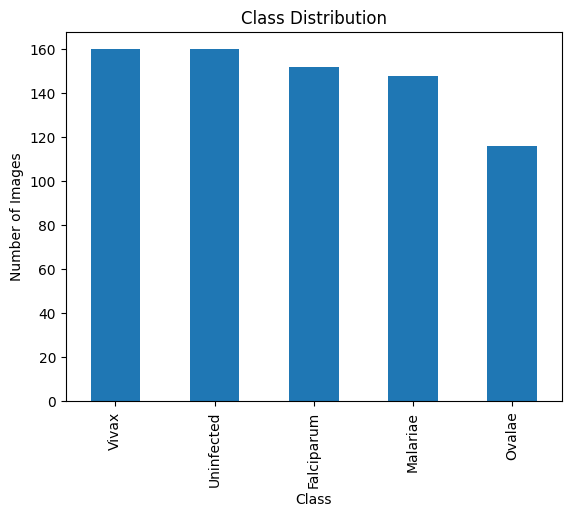

In [6]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [7]:
def extract_hog_features(df, img_size=64):
    X, y = [], []

    for img_path, label in tqdm(df[['image_path', 'label']].values):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))

        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm='L2-Hys'
        )

        X.append(features)
        y.append(label)

    return np.array(X), np.array(y)

In [8]:
X, y = extract_hog_features(df)
print("Feature shape:", X.shape)

100%|██████████| 736/736 [07:05<00:00,  1.73it/s]

Feature shape: (736, 1764)


In [11]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [24]:
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1, num_class=5, ...)

In [25]:
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.7027027027027027
              precision    recall  f1-score   support

  Falciparum       0.54      0.68      0.60        31
    Malariae       0.64      0.47      0.54        30
      Ovalae       0.68      0.65      0.67        23
  Uninfected       1.00      1.00      1.00        32
       Vivax       0.67      0.69      0.68        32

    accuracy                           0.70       148
   macro avg       0.70      0.70      0.70       148
weighted avg       0.71      0.70      0.70       148



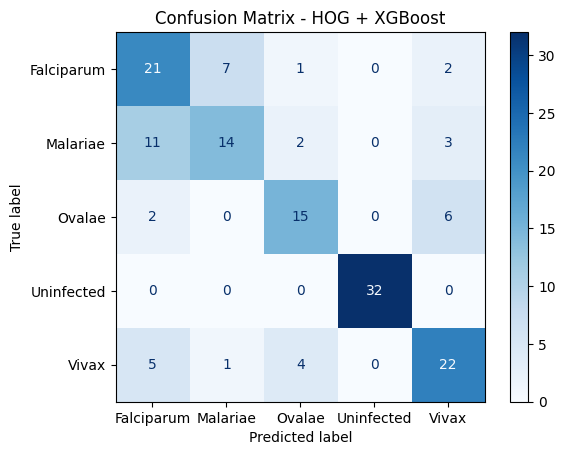

In [26]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - HOG + XGBoost")
plt.show()

In [27]:
import os

BASE_DIR = "/content/drive/MyDrive"
RF_VAL_DIR = os.path.join(BASE_DIR, "RF_Val")

os.makedirs(RF_VAL_DIR, exist_ok=True)

print("Saving to:", RF_VAL_DIR)

Saving to: /content/drive/MyDrive/RF_Val


In [28]:
from xgboost import Booster

XGB_MODEL_PATH = os.path.join(RF_VAL_DIR, "xgboost_model.json")

xgb_model.get_booster().save_model(XGB_MODEL_PATH)

print("XGBoost model saved at:", XGB_MODEL_PATH)

XGBoost model saved at: /content/drive/MyDrive/RF_Val/xgboost_model.json


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Confusion Matrix - HOG + XGBoost")

CM_PLOT_PATH = os.path.join(RF_VAL_DIR, "confusion_matrix_xgboost.png")
plt.savefig(CM_PLOT_PATH, dpi=300, bbox_inches="tight")
plt.close()

print("Confusion matrix plot saved at:", CM_PLOT_PATH)

Confusion matrix plot saved at: /content/drive/MyDrive/RF_Val/confusion_matrix_xgboost.png
